In [1]:
import tensorflow.keras as keras
import tensorflow as tf
import dataProcessing
import training
import utils
import data
from models.model import AttentionResNet
from models.refModel import RefConvNet

print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.0.0


In [2]:
seed = 1
tf.random.set_seed(seed)

In [10]:
x_train, y_train, x_test, y_test = utils.getCifar10Dataset()
x_train, y_train, x_test, y_test = dataProcessing.preprocessData(x_train, y_train, x_test, y_test,batch_size=128)
img_height = x_test.shape[1]
img_width = x_test.shape[2]
channels = x_test.shape[3]

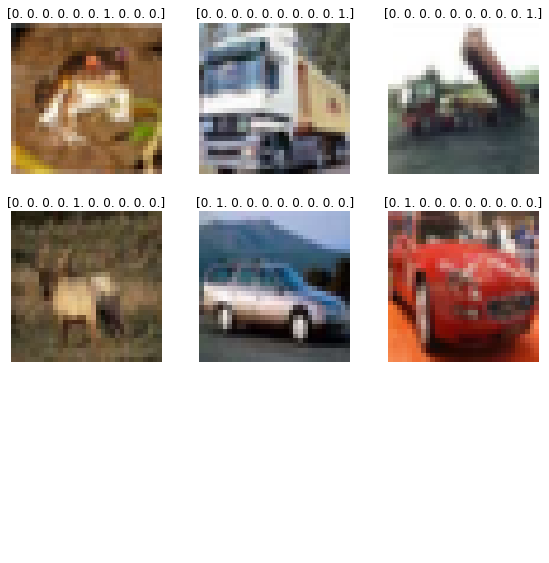

In [4]:
n_draw_images = 6
draw_images = x_train[:n_draw_images]
draw_labels = y_train[:n_draw_images]
utils.drawImages(draw_images, draw_labels)

In [5]:
batch_size = 128
x_train, y_train = dataProcessing.createBatches(x_train, y_train, batch_size)

In [7]:
hyperparameters = {}
hyperparameters['learning_rate'] = 0.1
hyperparameters['momentum'] = 0.9
hyperparameters['weight_decay'] = 0.0001
hyperparameters['epochs'] = 50
hyperparameters['batch_size'] = 128

In [6]:
# Reference model
if utils.isFile('model_weights/ref_model/ref_model.h5'):
    model = utils.loadKerasModel('model_weights', 'ref_model')
else:
    model = refModel.getRefConvNet(input_channels=32, input_shape=(32, 32, 3))
    model = trainModel(model, x_train, y_train, x_test, y_test, hyperparameters, 'ref_model', save_keras_model=True)

training.testModel(model, x_test, y_test, 'ref model')

[Testing] Test Accuracy: 10.00% for ref model


0

In [11]:
# AttentionResNet
model = AttentionResNet((img_height, img_width, channels))

In [ ]:
model = trainModel(model, x_train, y_train, x_test, y_test, hyperparameters, 'AttentionResNet', save_weights=True)

In [ ]:
training.testModel(model, x_test, y_test, 'AttentionResNet')